In [2]:
%load_ext autoreload
%autoreload 2
from src.generator.generator import Generator
from PIL import Image
from src.face_frame import face_frame_correction
import torch
from src.nets.MobileNetV2_unet import MobileNetV2_unet
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import src.face_frame as face_frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gen = Generator("http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl")
#gen = Generator("https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl")

In [4]:
model = MobileNetV2_unet(None).to(torch.device("cuda"))
state_dict = torch.load('./src/checkpoints/model.pt', map_location='cuda')
model.load_state_dict(state_dict)
model.eval()
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [23]:
def create_random_image(seed=13):
    #create random face
    z = torch.from_numpy(np.random.RandomState(
                seed).randn(1, gen.G.z_dim)).to(gen.device)
    w = gen.G.mapping(z=z, c=None, truncation_psi=gen.psi)
    random_image = gen.generate_image_from_w(w)
    image = Image.fromarray(random_image)
    return image



In [36]:
face = create_random_image(13)
target = create_random_image(8)




(-0.5, 1023.5, 1023.5, -0.5)

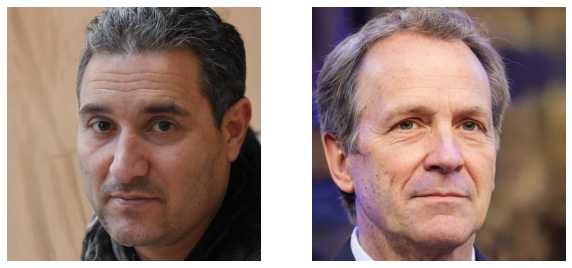

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(face)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(target)
plt.axis('off')

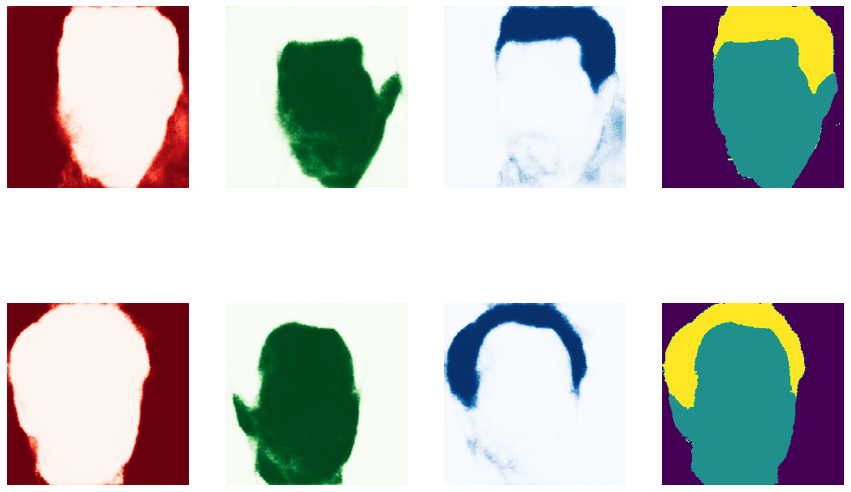

In [59]:
plt.figure(figsize=(15, 10))
images = [face, target]
segmentations = []
for idx, image in  enumerate(images):
    #segmentate image
    segmentation = face_frame.create_segmentation_mask(model, image)
    segmentation = segmentation.cpu().detach().numpy()
    segmentations.append(segmentation)

    #print the three masks

    plt.subplot(len(images), 4, 1 + 4*idx)
    plt.imshow(segmentation[0][0], cmap='Reds')
    plt.axis('off')

    plt.subplot(len(images), 4, 2+4*idx)
    plt.imshow(segmentation[0][1], cmap='Greens')
    plt.axis('off')
    plt.subplot(len(images), 4, 3+4*idx)
    plt.imshow(segmentation[0][2], cmap='Blues')
    plt.axis('off')

    #plot argmax
    plt.subplot(len(images), 4, 4+4*idx)
    plt.imshow(np.argmax(segmentation[0], axis=0))
    plt.axis('off')
face_segmentation = segmentations[0]
target_segmentation = segmentations[1]


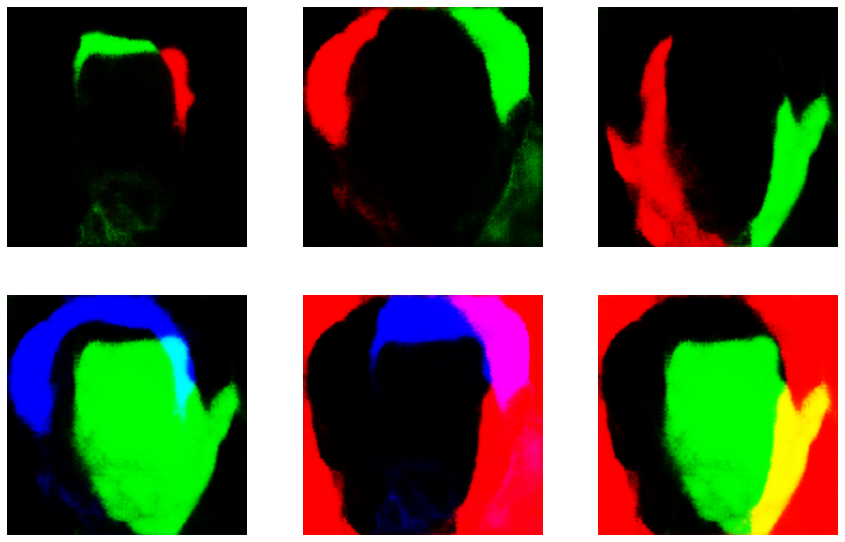

In [71]:
#plot the intersections between the masks
plt.figure(figsize=(15, 15))
FACE = 1
HAIR = 2
BACKGROUND = 0

target_background = target_segmentation[:, BACKGROUND, :, :]
target_face = target_segmentation[:, FACE, :, :]
target_hair = target_segmentation[:, HAIR, :, :]

output_background = face_segmentation[:, BACKGROUND, :, :]
output_face = face_segmentation[:, FACE, :, :]
output_hair = face_segmentation[:, HAIR, :, :]

#hair-face
plt.subplot(3, 3, 1)
image_red = target_hair[0] * output_face[0]
image_green = output_hair[0] * target_face[0]
image_blue = np.zeros_like(image_green)
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

#hair-background
plt.subplot(3, 3, 2)
image_red = target_hair[0] * output_background[0]
image_green = output_hair[0] * target_background[0]
image_blue = np.zeros_like(image_green)
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

#face-background
plt.subplot(3, 3, 3)
image_red = target_face[0] * output_background[0]
image_green = output_face[0] * target_background[0]
image_blue = np.zeros_like(image_green)
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

#plot masks 

plt.subplot(3, 3, 4)
image_red = np.zeros_like(target_face[0])
image_green = output_face[0]
image_blue = target_hair[0]
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

plt.subplot(3, 3, 5)
image_red =  target_background[0]
image_green = np.zeros_like(target_face[0])
image_blue = output_hair[0]
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

plt.subplot(3, 3, 6)
image_red =  target_background[0]
image_green = output_face[0]
image_blue = np.zeros_like(target_face[0])
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)


plt.subplot(3, 3, 7)
image_red = np.zeros_like(target_face[0])
image_green = target_face[0]
image_blue = output_hair[0]
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

plt.subplot(3, 3, 8)
image_red =  output_background[0]
image_green = np.zeros_like(target_face[0])
image_blue = target_hair[0]
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)

plt.subplot(3, 3, 9)
image_red =  output_background[0]
image_green = target_face[0]
image_blue = np.zeros_like(target_face[0])
image = np.stack([image_red, image_green, image_blue], axis=2)
plt.axis('off')
plt.imshow(image)